In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score, f1_score, precision_score, confusion_matrix

from keras import Sequential
from keras.layers import Dense, Input

pd.options.display.max_columns = None

In [137]:
def load() -> pd.DataFrame:
    df = pd.read_pickle("new_data.pickle")

    outsample = df[df["Date Announced"] > "2020-01-01"] # true out of sample, do not touch
    insample = df[df["Date Announced"] <= "2020-01-01"]

    return outsample, insample 

_, df = load()

In [138]:
df.head()

,Success,Date Announced,Date Effective,Date Withdrawn,Deal Number,Target Name,Target Primary Ticker Symbol,Target Industry Sector,Acquiror Name,Acquiror Primary Ticker Symbol,Acquiror Industry Sector,Exchange Ratio,Price Per Share,Acquiror's price per share,Acquiror Closing Price 1 Day After Ann Date ($),Acquiror Closing Price 60 Days After Ann Date ($),Acquiror Closing Price 90 Days After Ann Date ($),Acquiror Closing Price 180 Days After Ann Date ($),Target Share Price 1 Day Prior to Announcement ($),Target Closing Price 1 Day After Ann Date ($),Target Closing Price 60 Days After Ann Date ($),Target Closing Price 90 Days After Ann Date ($),Target Closing Price 180 Days After Ann Date ($),Premium 1 day prior to announce- ment date,Premium 1 week prior to announce- ment date,Premium 4 weeks prior to ann. date,S&P 500 Closing Price 1 Day Before Announcement,Poison Pill,% sought,Ratio of Offer Price to EPS,Ratio of Deal Value to Sales,Ratio of Deal Value to EBIT,Ratio of Deal Value to EBITDA,Ratio of Deal Value to Net Income,Ratio of Enterprise Value to Sales,Ratio of Enterprise Value to EBIT,Ratio of Enterprise Value to EBITDA,Ratio of Enterprise Value to Net Income,Equity Value/ Net Sales,Ratio of Equity Value to EBIT,Ratio of Equity Value at Announcement to EBITDA,Ratio of Equity Value to Net Income,Target Ebit 3-Year Growth Rate (%),Target Ebit 5-Year Growth Rate (%),EBIT Margin,Target EBITDA Three Year Growth Rate,Target EBITDA Five Year Growth Rate,EBITDA Margin,Target Net Assets Three Year Growth Rate,Target Net Assets Five Year Growth Rate,Target Net Sales 5-Year Growth Rate (%),Total Fee %,Target Fee %,Target Total Assets 5-Year Growth Rate (%),Target Total Lia. 5-Year Growth Rate (%),Common Equity Multiple,Value / Net Assets,EBIT / Return on Assets,EBITDA ROA,Enterprise Value / Net Assets,Enterprise Value / Pre-tax Inc,Enterprise Value / Tangible Book Value,Ratio of Offer Price to Book Value,Target Net Sales LTM ($mil),EBIT Last Twelve Months ($ Mil),Pre-tax Income Last Twelve Months ($ Mil),Net Income Last Twelve Months ($ Mil),Target Net Assets ($mil),Target Total Assets ($mil),Target EBITDA LTM ($mil),Target Book Value Per Share LTM (US$),Target Common Equity ($mil),Target Earnings Per Share LTM (US$),Value Based on Effective Date ($mil),Value Common at Eff. Date ($mil),Equity Value at Effective Date ($mil),Target Book Value/sh One Year Prior,Target Book Value/sh Two Years Prior,Target Book Value/sh Three Years Prior,Target Capital Expend. One Year Prior ($ mil),Target Capital Expend. Two Years Prior ($ mil),Target Capital Expend. Three Years Prior ($ mil),Target Cash & Mktbl. Securities One Year Prior ($ mil),Target Cash & Mktbl. Securities Two Years Prior ($ mil),Target Cash & Mktbl. Securities Three Years Prior ($ mil),Host Curr. Target Long Term Debt One Year Prior (mil),Host Curr. Target Long Term Debt Two Years Prior (mil),Host Curr. Target Long Term Debt Three Years Prior (mil),Target Long- Term Liab. 1-Year Prior ($ mil),Target Long- Term Liab. 2-Years Prior ($ mil),Target Long- Term Liab. 3-Years Prior ($ mil),Target Net Cash Fr. Investing One Year Prior,Target Net Cash Fr. Investing Two Years Prior,Target Net Cash Fr. Investing Three Years Prior,Target Net Cash fr. Financing One Year Prior,Target Net Cash fr. Financing Two Years Prior,Target Net Cash fr. Financing Three Years Prior,Target Straight Debt One Year Prior ($ mil),Target Straight Debt Two Years Prior ($ mil),Target Straight Debt Three Years Prior ($ mil)
3,0,2012-01-13,NaT,2012-05-04,2379612020,Georgia Gulf Corp,GGC,Chemicals and Allied Products,Westlake Chemical Corp,WLK,Chemicals and Allied Products,NaN,35.00,NaN,56.340,65.690,61.120,54.010,24.48,33.48,33.07,32.06,27.23,42.97,62.94,89.39,1295.50,Yes,95.2,21.0,0.372,8.9,5.067,21.199,0.533,12.718,7.260,30.376,0.372,8.877,5.067,21.200,118.999,-7.857,0.042,27.36,-8.503,0.073,13.90,25.53,0.52,NaN,NaN,-7.09,-12.94,2.453,2.5,0.082,0.144,3.515,32.078,7.521,2.452,3222.884,135.038,53.5,56.5,488.7,1640.4

## train model (sample)

In [139]:
cols_df = pd.read_csv("columns_to_select.csv")

minmax_cols = cols_df[cols_df["kind"] == "ratio"]["column_names"].values # columns that are already in terms of ratios, send direct to minmax/std scaler
scalar_cols = cols_df[cols_df["kind"] == "scalar"]["column_names"].values # columns that are in abs terms


all_cols = cols_df[cols_df["kind"].isin(["ratio","scalar"])]["column_names"].values


In [140]:
X = df[all_cols]
y = df["Success"]

train_len = int(len(df) * 0.75)
X.shape, y.shape

((1196, 72), (1196,))

In [141]:
X_train = X.iloc[:train_len,:]
y_train = y.iloc[:train_len]

X_test = X.iloc[train_len:,:]
y_test = y.iloc[train_len:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((897, 72), (897,), (299, 72), (299,))

In [142]:
imputer = SimpleImputer(missing_values=np.nan, strategy="median")
imputer.fit(X_train)

X_train_imputed = pd.DataFrame(imputer.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), index=X_test.index, columns=X_test.columns)

X_train_imputed.isnull().any().any(), X_test_imputed.isnull().any().any(), X_train_imputed.shape, X_test_imputed.shape

(False, False, (897, 72), (299, 72))

In [143]:
scaler = MinMaxScaler().fit(X_train_imputed)

X_train_norm = pd.DataFrame(scaler.transform(X_train_imputed), index=X_train_imputed.index, columns=X_train_imputed.columns)
X_test_norm = pd.DataFrame(scaler.transform(X_test_imputed), index=X_test_imputed.index, columns=X_test_imputed.columns)

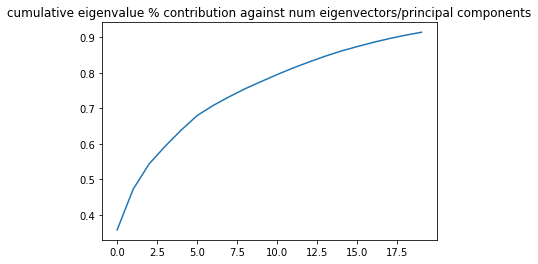

In [144]:
pca = PCA(n_components=20)
pca.fit(X_train_norm)

plt.plot(pca.explained_variance_ratio_.cumsum(), "-")
plt.title("cumulative eigenvalue % contribution against num eigenvectors/principal components")
plt.show()

In [145]:
X_train_pca = pd.DataFrame(pca.transform(X_train_norm), index=X_train_norm.index)
X_test_pca = pd.DataFrame(pca.transform(X_test_norm), index=X_test_norm.index)

X_train_pca.shape, X_test_pca.shape

((897, 20), (299, 20))

In [150]:
## train dummy classifier (predict True for all events)

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_pca, y_train)
yhat_dummy = dummy.predict(X_test_pca)
dummy.score(X_test_pca, y_test), precision_score(y_test, yhat_dummy)

(0.9063545150501672, 0.9063545150501672)

In [151]:
# train classifier

clf = GradientBoostingClassifier()

clf.fit(X_train_pca, y_train)

yhat = clf.predict(X_test_pca)
clf.score(X_test_pca, y_test), precision_score(y_test, yhat)

(0.8862876254180602, 0.9128919860627178)

In [153]:
confusion_matrix(y_test, yhat)

array([[  3,  25],
       [  9, 262]], dtype=int64)